- https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
- 오버피팅을 줄이면서 90% 이상의 정확도를 가지는 아키텍쳐 구현

In [1]:
# validation data 양이 최소 train data 양의 10%는 넘어야 함

In [5]:
#Open_CV
# Classification --> CNN, TL
# Detection -->fast R-CNN, Yolo8, SSD
# Segmentation --> Unet

# validation data number 가 부족함 --> validation data will be extracted from train data set
# Original validation data will be moved to test data set

In [1]:
# !pip install scikit-learn


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
## GPU 사용 유무 확인
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2023-07-06 15:22:27.690264: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 15:22:29.007944: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-06 15:22:29.013555: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-06 15:22:29.013750: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been bu

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3462994604466359084
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9824108544
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13409120711108661089
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:2b:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow.keras.utils as utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score

from datetime import datetime
import cv2
import zipfile
import shutil
import os
import glob

from tensorflow.keras.applications import Xception, ResNet50
from tensorflow.keras.applications import InceptionV3, MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Project -1

### 경로 설정

In [3]:
#현재 폴더 경로; 작업 폴더 기준
print(os.getcwd())

/tf/Kaggle Portfolio


In [4]:
#### PC
ROOT_DIR = "/tf/Kaggle Portfolio"
DATA_ROOT_DIR = os.path.join(ROOT_DIR, "Chest_Xray_Pneumonia")
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "train")
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "test")
VALIDATION_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "val")

### 데이터셋 가져오기

In [9]:
# #### Colab
# from google.colab import drive

# drive.mount("/content/gdrive")

# data_path = "/content/gdrive/MyDrive/Colab Notebooks"

# shutil.copy(os.path.join(data_path, "Chest_Xray_Pneumonia.zip"), ROOT_DIR) # zip file name
    
# with zipfile.ZipFile(os.path.join(ROOT_DIR, "Chest_Xray_Pneumonia.zip"), "r") as target_file:
#     target_file.extractall(DATA_ROOT_DIR)

In [8]:
#### PC

if os.path.exists(DATA_ROOT_DIR):
    shutil.rmtree(DATA_ROOT_DIR)
    
with zipfile.ZipFile(os.path.join(ROOT_DIR, "archive_pneumonia.zip"), "r") as target_file:
    target_file.extractall(DATA_ROOT_DIR)

#Data 재가공 불필요한 file 정리 후 colab에 사용하기위한 알맞는 data set form(train, test, val)으로 압축

### 데이터 경로 재설정

In [5]:
#### PC
ROOT_DIR = "/tf/Kaggle Portfolio/Chest_Xray_Pneumonia"
DATA_ROOT_DIR = os.path.join(ROOT_DIR, "chest_xray")
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "train")
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "test")
VALIDATION_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "val")


### 정답 및 전체 데이터 갯수 확인

In [6]:
##### 훈련 데이터 갯수

train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for label_name in train_label_name_list:
    print('train label : ', label_name,' => ', 
          len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

print('=====================================================')

##### 테스트 데이터 갯수
test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)

for label_name in test_label_name_list:
    print('test label : ', label_name,' => ', 
          len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))))
    
print('=====================================================')

##### 평가 데이터 갯수
validation_label_name_list = os.listdir(VALIDATION_DATA_ROOT_DIR)
print(validation_label_name_list)

for label_name in validation_label_name_list:
    print('validation label : ', label_name,' => ', 
          len(os.listdir(os.path.join(VALIDATION_DATA_ROOT_DIR, label_name))))


['NORMAL', 'PNEUMONIA']
train label :  NORMAL  =>  1267
train label :  PNEUMONIA  =>  3419
['NORMAL', 'PNEUMONIA']
test label :  NORMAL  =>  316
test label :  PNEUMONIA  =>  854
['NORMAL', 'PNEUMONIA']
validation label :  NORMAL  =>  0
validation label :  PNEUMONIA  =>  0


### Image Shape 설정

In [7]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

### ImageDataGenerator를 이용하여 데이터 불러오기

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
train_generator = train_datagen.flow_from_directory(TRAIN_DATA_ROOT_DIR, 
                                                    batch_size=50,
                                                color_mode='rgb', 
                                                    class_mode='sparse',
                                                target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                subset = "training")

validation_generator = validation_datagen.flow_from_directory(TRAIN_DATA_ROOT_DIR, 
                                                  batch_size=50, 
                                              color_mode='rgb', 
                                                  class_mode='sparse',
                                              target_size=(IMG_WIDTH,IMG_HEIGHT),
                                              subset = "validation")


test_generator = test_datagen.flow_from_directory(TEST_DATA_ROOT_DIR, 
                                                  batch_size=50, 
                                              color_mode='rgb', 
                                                  class_mode='sparse',
                                              target_size=(IMG_WIDTH,IMG_HEIGHT))



Found 3750 images belonging to 2 classes.
Found 936 images belonging to 2 classes.
Found 1170 images belonging to 2 classes.


In [12]:
print(train_generator.class_indices)
print(train_generator.num_classes)

{'NORMAL': 0, 'PNEUMONIA': 1}
2


### 16장의 이미지 확인

- ImageDataGenerator를 통해 전달된 이미지 출력

In [13]:
data, label = train_generator.next()

data = data[:16]
label = label[:16]
print(data.shape, label.shape)
print(label)

(16, 224, 224, 3) (16,)
[0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1.]


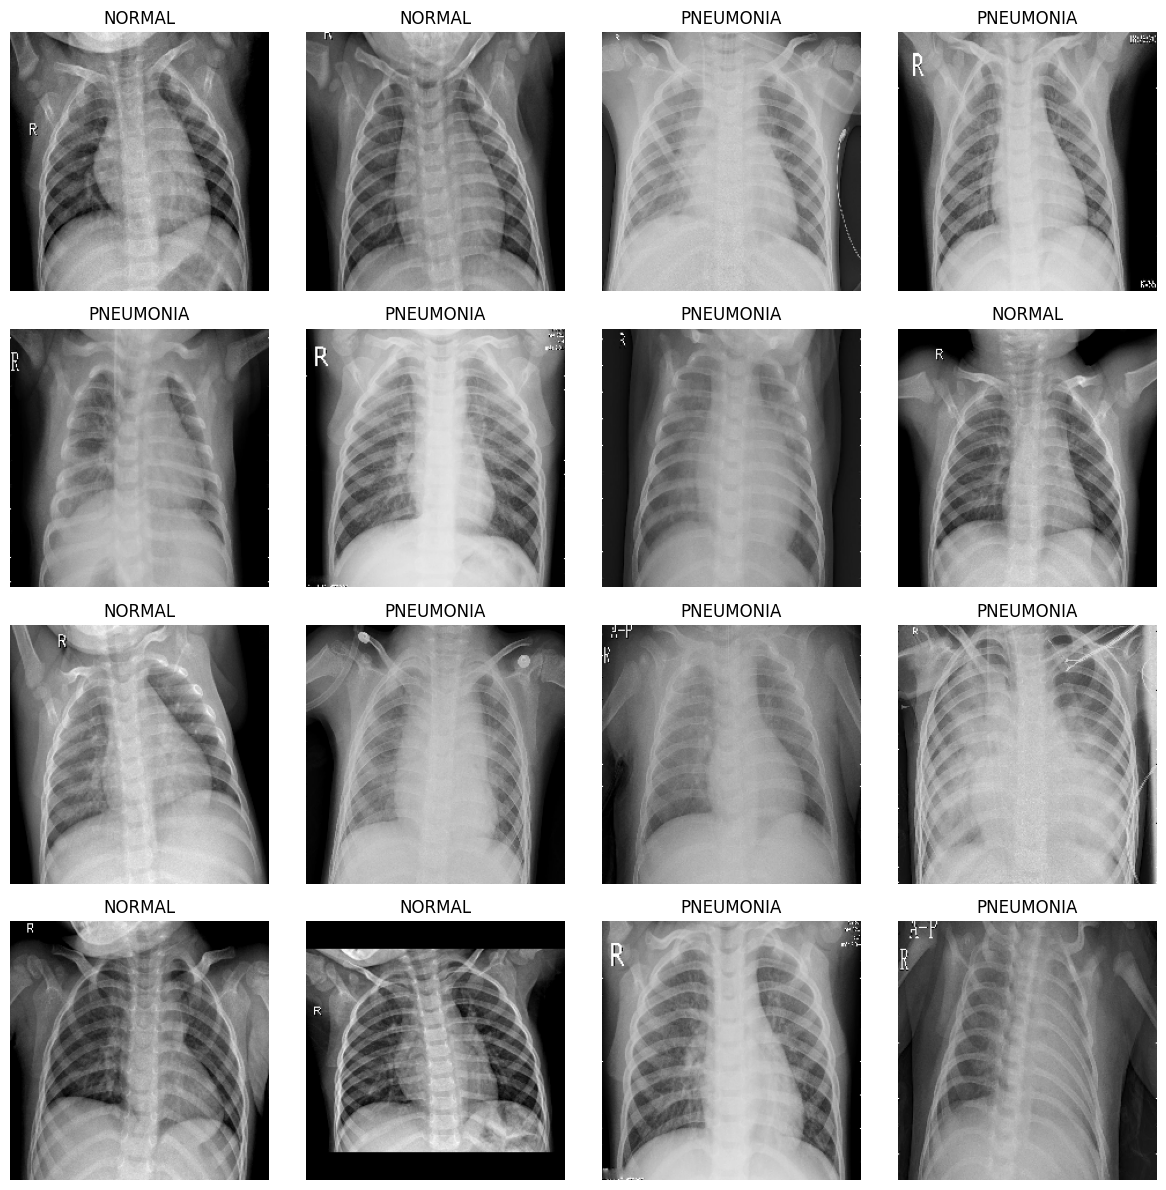

In [14]:
plt.figure(figsize=(12, 12))

class_dict = {0:'NORMAL', 1:'PNEUMONIA'}

for i in range(len(label)):
    plt.subplot(4, 4, i+1)
    plt.axis("off")
    plt.title(class_dict[label[i]])
    plt.imshow(data[i])

plt.tight_layout()

### Fine Tunning을 위한 pre-trained 정의 및 모델 구축

In [15]:
#MobilNet 을 이용한 deep learning 모델 학습
pre_trained_model = MobileNet(weights="imagenet", include_top=False,
                             input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
pre_trained_model.summary()

2023-07-06 15:23:12.678617: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-06 15:23:12.678895: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-06 15:23:12.679296: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-06 15:23:12.679662: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-06 15:23:12.679956: I tensorflow/compile

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

In [16]:
model = Sequential()

model.add(pre_trained_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(16, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(train_generator.num_classes, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 16)                16400     
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 3,245,298
Trainable params: 3,223,410
Non-

In [17]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer=Adam(1e-5), metrics=["accuracy"])

In [18]:
start_time = datetime.now()

# epochs = 60
result = model.fit(train_generator, epochs= 50, validation_data=validation_generator)

end_time = datetime.now()
print("Elapsed Time : ", end_time - start_time)

Epoch 1/50


2023-07-06 15:23:36.188426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-07-06 15:23:40.551630: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-06 15:23:41.883452: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-06 15:23:41.886392: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f2fbad94050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-06 15:23:41.886415: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-07-06 15:23:41.88956

75/75 [==============================] - ETA: 0s - loss: 1.5222 - accuracy: 0.5277

2023-07-06 15:24:17.786994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


75/75 [==============================] - 49s 492ms/step - loss: 1.5222 - accuracy: 0.5277 - val_loss: 0.3441 - val_accuracy: 0.8643
Epoch 2/50
75/75 [==============================] - 36s 481ms/step - loss: 0.6462 - accuracy: 0.7571 - val_loss: 0.2532 - val_accuracy: 0.8964
Epoch 3/50
75/75 [==============================] - 37s 495ms/step - loss: 0.3843 - accuracy: 0.8472 - val_loss: 0.2202 - val_accuracy: 0.9209
Epoch 4/50
75/75 [==============================] - 33s 446ms/step - loss: 0.3210 - accuracy: 0.8848 - val_loss: 0.2076 - val_accuracy: 0.9231
Epoch 5/50
75/75 [==============================] - 37s 488ms/step - loss: 0.2521 - accuracy: 0.9053 - val_loss: 0.1877 - val_accuracy: 0.9295
Epoch 6/50
75/75 [==============================] - 36s 485ms/step - loss: 0.2357 - accuracy: 0.9165 - val_loss: 0.1482 - val_accuracy: 0.9444
Epoch 7/50
75/75 [==============================] - 36s 481ms/step - loss: 0.1858 - accuracy: 0.9347 - val_loss: 0.1239 - val_accuracy: 0.9562
Epoch 8/50

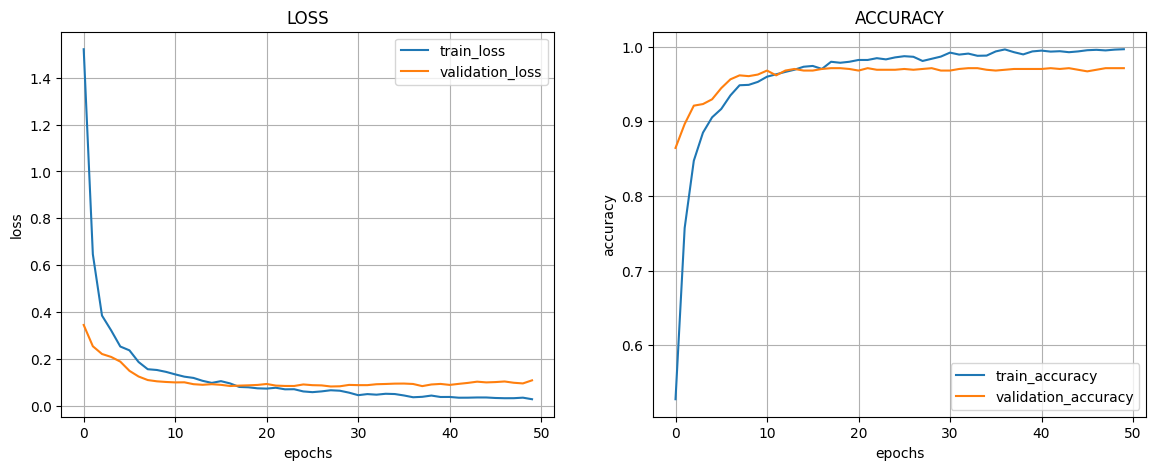

In [19]:
#LOSS graph
fig = plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best")

#ACCURACY graph
plt.subplot(1, 2, 2)
plt.title("ACCURACY")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.grid()

plt.plot(result.history["accuracy"], label="train_accuracy")
plt.plot(result.history["val_accuracy"], label="validation_accuracy")
plt.legend(loc="best")


In [20]:
print(model.evaluate(test_generator))

2023-07-06 15:52:42.485406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


24/24 [==============================] - 9s 364ms/step - loss: 0.0933 - accuracy: 0.9752
[0.09326411783695221, 0.9752136468887329]


In [21]:
print(model.evaluate(validation_generator))

2023-07-06 15:52:53.314632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


19/19 [==============================] - 7s 352ms/step - loss: 0.1075 - accuracy: 0.9712
[0.10752761363983154, 0.9711538553237915]


In [32]:
test_simple_dataget = ImageDataGenerator(rescale = 1./255)

test_simple_generator = train_datagen.flow_from_directory(VALIDATION_DATA_ROOT_DIR, 
                                                    batch_size=32,
                                                color_mode='rgb', 
                                                    class_mode='sparse',
                                                target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 0 images belonging to 2 classes.


In [34]:
# model.evaluate(test_simple_generator)

ValueError: Asked to retrieve element 0, but the Sequence has length 0

### Project -1 loss, accuracy 확인
#### Model architecture
- pretrained model : MobileNet(weights=imagenet) - F - D - D
- dropout: 0.5
- number of node : 16
- optimizer : Adam
- learning rate : 2e-5
- epochs : 40
- Train
    loss: 1.6097e-05, accuracy: 1.0000
- Test
    loss: 1.6094, accuracy: 0.7933
- Validation
    loss: 0.0402 - accuracy: 0.9914
- Elapsed Time :  0:26:04.697911
- 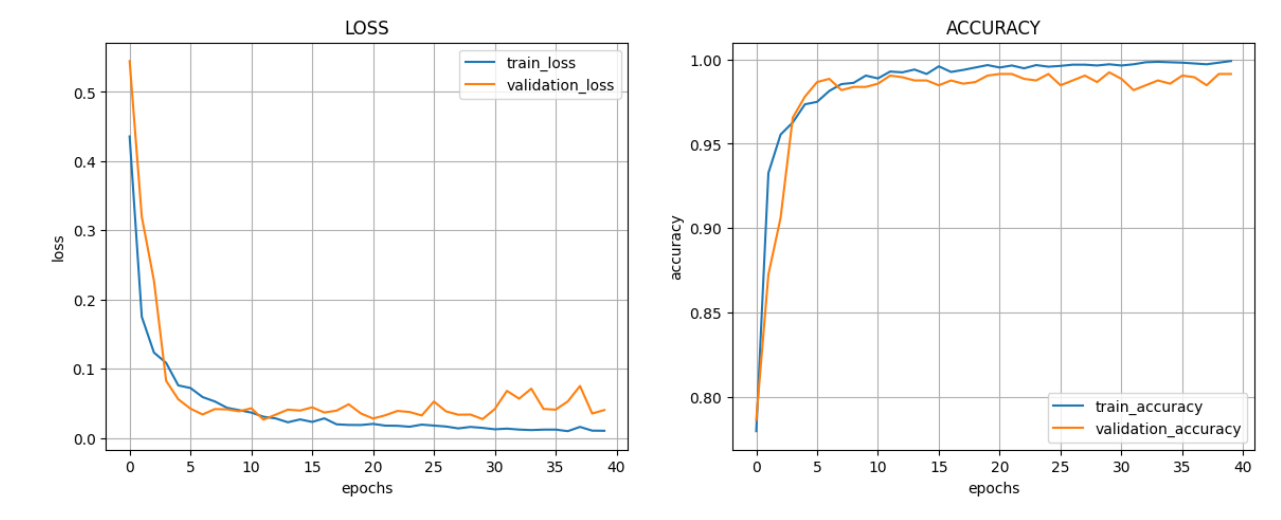

# Project-2

### Testing 디렉토리의 모든 파일을 Training 동일 디렉토리로 move

In [35]:
test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)

['NORMAL', 'PNEUMONIA']


In [36]:
for label_name in test_label_name_list:
    test_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)
    test_file_list = os.listdir(test_path)
    
    train_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    
    move_num = 0
    for test_file in test_file_list:
        shutil.move(os.path.join(test_path, test_file),
                   os.path.join(train_path, test_file))
        move_num = move_num + 1
        
    print(str(move_num) + " is moved into " + label_name + \
          "(Testing => Training)")

316 is moved into NORMAL(Testing => Training)
854 is moved into PNEUMONIA(Testing => Training)


In [37]:
for label_name in test_label_name_list:
    val_path = os.path.join(VALIDATION_DATA_ROOT_DIR, label_name)
    val_file_list = os.listdir(val_path)
    
    train_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    
    move_num = 0
    for val_file in val_file_list:
        shutil.move(os.path.join(val_path, val_file),
                   os.path.join(train_path, val_file))
        move_num = move_num + 1
        
    print(str(move_num) + " is moved into " + label_name + \
          "(Testing => Training)")

0 is moved into NORMAL(Testing => Training)
0 is moved into PNEUMONIA(Testing => Training)


### move 완료된 Trainning 전체 데이터 갯수 확인

In [38]:
train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for label_name in train_label_name_list:
    print('train label : ', label_name,' => ', 
          len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

['NORMAL', 'PNEUMONIA']
train label :  NORMAL  =>  1583
train label :  PNEUMONIA  =>  4273


### Shuffle 후 다시 Tesing으로 move

In [39]:
##### move할 파일의 비율
MOVE_RATIO = 0.2

In [40]:
label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
for label_name in label_name_list:
    # 파일 move 하기 위한 src_dir_path, dst_dir_path 설정
    #=========================================================
    src_dir_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    dst_dir_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)
    #=========================================================

    train_data_file_list = os.listdir(src_dir_path)
    print('========================================================================')
    print('total [%s] data file nums => [%s]' % (label_name,
                                                 len(train_data_file_list)))

    # data shuffle
    np.random.shuffle(train_data_file_list)
    print('train data shuffle is done !!!')

    split_num = int(MOVE_RATIO*len(train_data_file_list))
    print('split nums => ', split_num)

    # extract test data from train data
    test_data_file_list = train_data_file_list[0:split_num]

    move_nums = 0
    for test_data_file in test_data_file_list:
        try:
            shutil.move(os.path.join(src_dir_path, test_data_file),
                        os.path.join(dst_dir_path, test_data_file))
        except Exception as err:
            print(str(err))

        move_nums = move_nums + 1

    print('total move nums => ', move_nums)
    print('========================================================================')


total [NORMAL] data file nums => [1583]
train data shuffle is done !!!
split nums =>  316
total move nums =>  316
total [PNEUMONIA] data file nums => [4273]
train data shuffle is done !!!
split nums =>  854
total move nums =>  854


In [41]:
##### 훈련 데이터 갯수
train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for label_name in train_label_name_list:
    print('train label : ', label_name,' => ', 
          len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

print('=====================================================')

##### 테스트 데이터 갯수
test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)

for label_name in test_label_name_list:
    print('test label : ', label_name,' => ', 
          len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))))
    
print('=====================================================')


['NORMAL', 'PNEUMONIA']
train label :  NORMAL  =>  1267
train label :  PNEUMONIA  =>  3419
['NORMAL', 'PNEUMONIA']
test label :  NORMAL  =>  316
test label :  PNEUMONIA  =>  854


### Image Shape 설정

In [42]:
IMG_WIDTH = 224 # GPU 사용시 224로 설정
IMG_HEIGHT = 224

### ImageDataGenerator를 이용하여 데이터 불러오기

In [43]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

In [44]:
train_generator = train_datagen.flow_from_directory(TRAIN_DATA_ROOT_DIR, 
                                                    batch_size=32,
                                                color_mode='rgb', 
                                                    class_mode='sparse',
                                                target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                subset = "training")

validation_generator = validation_datagen.flow_from_directory(TRAIN_DATA_ROOT_DIR, 
                                                  batch_size=32, 
                                              color_mode='rgb', 
                                                  class_mode='sparse',
                                              target_size=(IMG_WIDTH,IMG_HEIGHT),
                                              subset = "validation")


test_generator = test_datagen.flow_from_directory(TEST_DATA_ROOT_DIR, 
                                                  batch_size=32, 
                                              color_mode='rgb', 
                                                  class_mode='sparse',
                                              target_size=(IMG_WIDTH,IMG_HEIGHT))



Found 3750 images belonging to 2 classes.
Found 936 images belonging to 2 classes.
Found 1170 images belonging to 2 classes.


In [45]:
print(train_generator.class_indices)
print(train_generator.num_classes)

{'NORMAL': 0, 'PNEUMONIA': 1}
2


### 16장의 이미지 확인

- ImageDataGenerator를 통해 전달된 이미지 출력

In [46]:
data, label = train_generator.next()

data = data[:16]
label = label[:16]
print(data.shape, label.shape)
print(label)

(16, 224, 224, 3) (16,)
[1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]


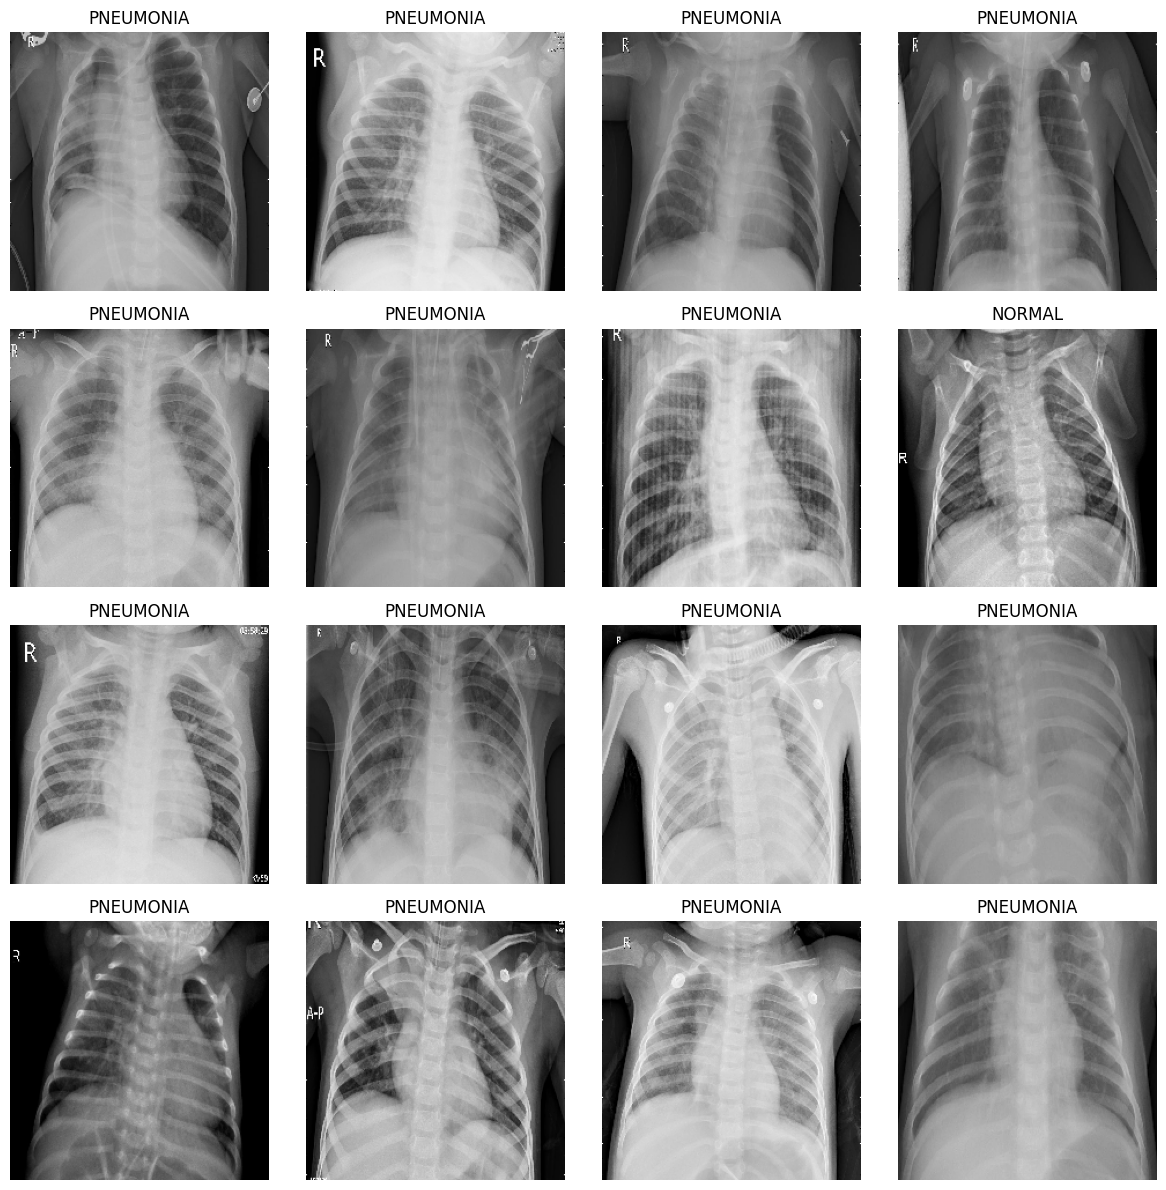

In [47]:
plt.figure(figsize=(12, 12))

class_dict = {0:'NORMAL', 1:'PNEUMONIA'}

for i in range(len(label)):
    plt.subplot(4, 4, i+1)
    plt.axis("off")
    plt.title(class_dict[label[i]])
    plt.imshow(data[i])

plt.tight_layout()

### Fine Tunning을 위한 pre-trained 정의 및 모델 구축

In [51]:
pre_trained_model = MobileNet(weights="imagenet", include_top=False,
                             input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
pre_trained_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

In [ ]:
model = Sequential()

model.add(pre_trained_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(16, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(train_generator.num_classes, activation="softmax"))

model.summary()

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer=Adam(1e-7), metrics=["accuracy"])

In [ ]:
# optimizer adam, learning rate 를 1e-7로 변경 후 epochs 를 80으로 늘려보았다
start_time = datetime.now()

result = model.fit(train_generator, epochs= 80, validation_data=validation_generator)

end_time = datetime.now()
print("Elapsed Time : ", end_time - start_time)

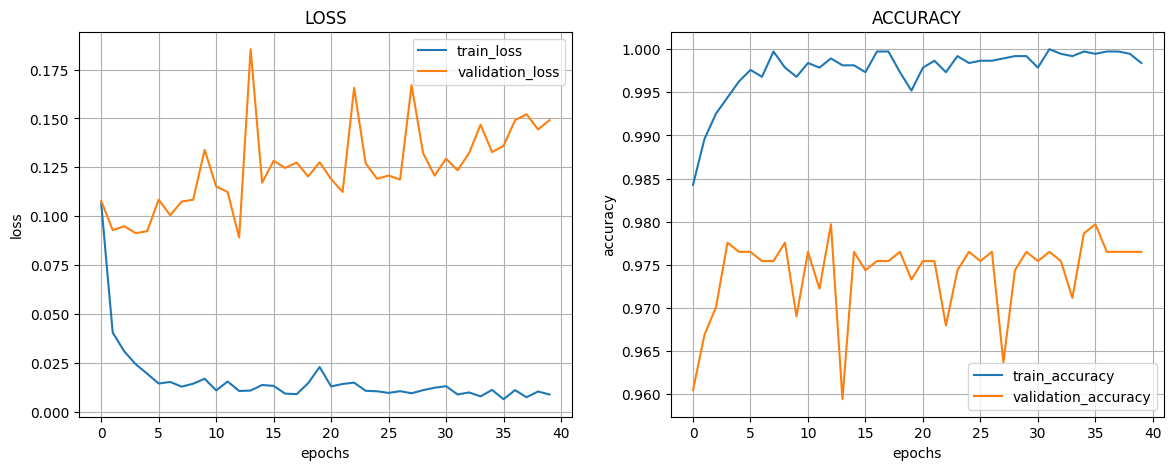

In [66]:
#LOSS graph
fig = plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best")

#ACCURACY graph
plt.subplot(1, 2, 2)
plt.title("ACCURACY")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.grid()

plt.plot(result.history["accuracy"], label="train_accuracy")
plt.plot(result.history["val_accuracy"], label="validation_accuracy")
plt.legend(loc="best")


In [57]:
print(model.evaluate(test_generator))

2023-07-05 17:19:00.622876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


37/37 [==============================] - 10s 255ms/step - loss: 0.0528 - accuracy: 0.9923
[0.052845001220703125, 0.9923076629638672]


In [59]:
print(model.evaluate(train_generator))

2023-07-05 17:19:32.591474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


118/118 [==============================] - 27s 227ms/step - loss: 1.7179e-06 - accuracy: 1.0000
[1.7178815596707864e-06, 1.0]


In [62]:
test_simple_dataget = ImageDataGenerator(rescale = 1./255)

test_simple_generator = train_datagen.flow_from_directory(VALIDATION_DATA_ROOT_DIR,
                                                    batch_size=32,
                                                color_mode='rgb', 
                                                    class_mode='sparse',
                                                target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 0 images belonging to 2 classes.


In [63]:
model.evaluate(test_simple_generator)

ValueError: Asked to retrieve element 0, but the Sequence has length 0

In [ ]:
##  학습이 잘 되었다
## Test : loss: 0.0528 - accuracy: 0.9923

-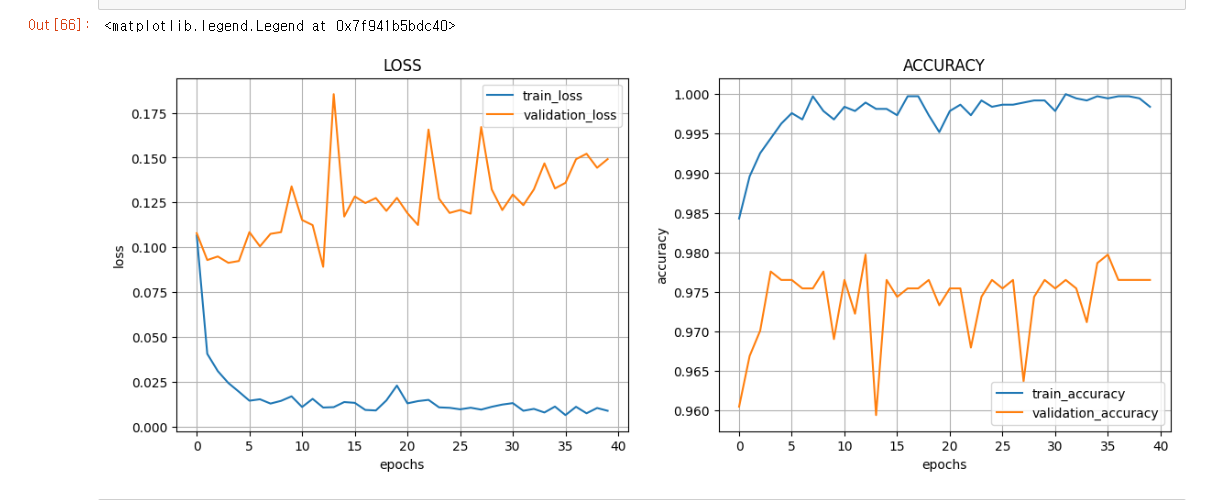

# Project - 3

In [ ]:
### pre-train model 변경

In [22]:
##### 훈련 데이터 갯수
train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for label_name in train_label_name_list:
    print('train label : ', label_name,' => ', 
          len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

print('=====================================================')

##### 테스트 데이터 갯수
test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)

for label_name in test_label_name_list:
    print('test label : ', label_name,' => ', 
          len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))))
    
print('=====================================================')


['NORMAL', 'PNEUMONIA']
train label :  NORMAL  =>  1267
train label :  PNEUMONIA  =>  3419
['NORMAL', 'PNEUMONIA']
test label :  NORMAL  =>  316
test label :  PNEUMONIA  =>  854


### Image Shape 설정

In [31]:
IMG_WIDTH = 224 # GPU 사용시 224로 설정
IMG_HEIGHT = 224

### ImageDataGenerator를 이용하여 데이터 불러오기

In [32]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

In [33]:
train_generator = train_datagen.flow_from_directory(TRAIN_DATA_ROOT_DIR, 
                                                    batch_size=32,
                                                color_mode='rgb', 
                                                    class_mode='sparse',
                                                target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                subset = "training")

validation_generator = validation_datagen.flow_from_directory(TRAIN_DATA_ROOT_DIR, 
                                                  batch_size=32, 
                                              color_mode='rgb', 
                                                  class_mode='sparse',
                                              target_size=(IMG_WIDTH,IMG_HEIGHT),
                                              subset = "validation")


test_generator = test_datagen.flow_from_directory(TEST_DATA_ROOT_DIR, 
                                                  batch_size=32, 
                                              color_mode='rgb', 
                                                  class_mode='sparse',
                                              target_size=(IMG_WIDTH,IMG_HEIGHT))



Found 3750 images belonging to 2 classes.
Found 936 images belonging to 2 classes.
Found 1170 images belonging to 2 classes.


In [34]:
print(train_generator.class_indices)
print(train_generator.num_classes)

{'NORMAL': 0, 'PNEUMONIA': 1}
2


### Fine Tunning을 위한 pre-trained 정의 및 모델 구축

- https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50
- Tensorflow 에서 ResNet50 architecture 를 참고 하였습니다.
- optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3)
- average pooling 사용

In [35]:
#ResNet50 을 이용한 deep learning 모델 학습
pre_trained_model = ResNet50(weights="imagenet", include_top=False,
                             input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
pre_trained_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [36]:
model = Sequential()

model.add(pre_trained_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(16, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(train_generator.num_classes, activation="softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 16)                32784     
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 2)                 34        
                                                                 
Total params: 23,620,530
Trainable params: 23,567,410
Non-trainable params: 53,120
_____________________________________

In [37]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer=Adam(1e-5), metrics=["accuracy"])

In [38]:
start_time = datetime.now()


result = model.fit(train_generator, epochs= 50, validation_data=validation_generator)

end_time = datetime.now()
print("Elapsed Time : ", end_time - start_time)

Epoch 1/50


2023-07-06 16:12:24.153608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


118/118 [==============================] - ETA: 0s - loss: 0.4159 - accuracy: 0.7931

2023-07-06 16:13:17.939431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


118/118 [==============================] - 62s 318ms/step - loss: 0.4159 - accuracy: 0.7931 - val_loss: 1.9920 - val_accuracy: 0.7297
Epoch 2/50
118/118 [==============================] - 34s 292ms/step - loss: 0.2155 - accuracy: 0.9285 - val_loss: 1.7263 - val_accuracy: 0.7297
Epoch 3/50
118/118 [==============================] - 34s 287ms/step - loss: 0.1394 - accuracy: 0.9520 - val_loss: 1.0102 - val_accuracy: 0.4380
Epoch 4/50
118/118 [==============================] - 34s 285ms/step - loss: 0.0975 - accuracy: 0.9675 - val_loss: 1.3102 - val_accuracy: 0.4925
Epoch 5/50
118/118 [==============================] - 34s 285ms/step - loss: 0.0666 - accuracy: 0.9856 - val_loss: 1.2639 - val_accuracy: 0.6955
Epoch 6/50
118/118 [==============================] - 34s 286ms/step - loss: 0.0479 - accuracy: 0.9872 - val_loss: 1.8391 - val_accuracy: 0.7297
Epoch 7/50
118/118 [==============================] - 34s 286ms/step - loss: 0.0413 - accuracy: 0.9899 - val_loss: 2.0197 - val_accuracy: 0.7

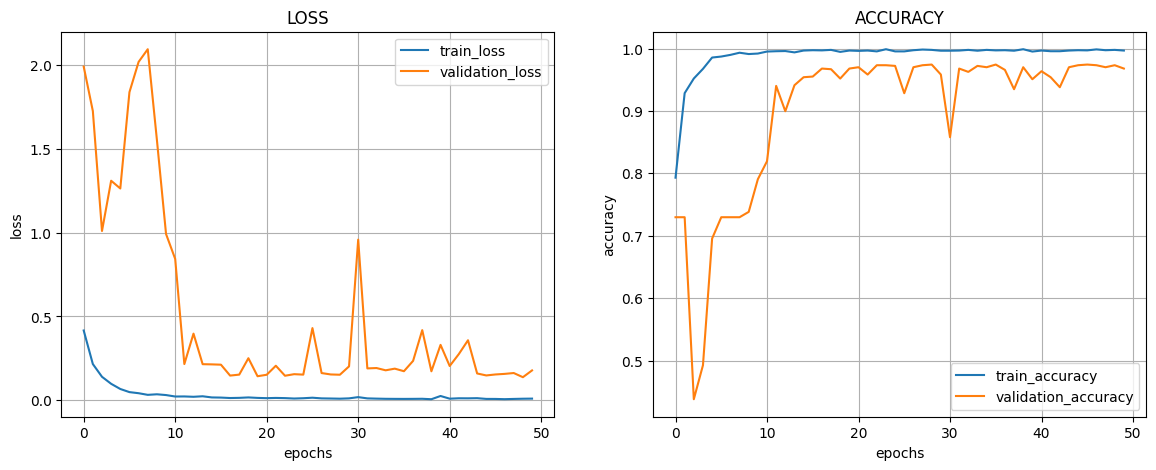

In [39]:
#LOSS graph
fig = plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best")

#ACCURACY graph
plt.subplot(1, 2, 2)
plt.title("ACCURACY")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.grid()

plt.plot(result.history["accuracy"], label="train_accuracy")
plt.plot(result.history["val_accuracy"], label="validation_accuracy")
plt.legend(loc="best")


In [40]:
print(model.evaluate(test_generator))

2023-07-06 16:42:34.916217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


37/37 [==============================] - 9s 244ms/step - loss: 0.1454 - accuracy: 0.9744
[0.14543546736240387, 0.9743589758872986]


In [41]:
print(model.evaluate(validation_generator))

2023-07-06 16:42:49.297547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


30/30 [==============================] - 7s 214ms/step - loss: 0.1774 - accuracy: 0.9679
[0.17743684351444244, 0.9679487347602844]


In [ ]:
"""
pretrained model : ResNet50(weights=imagenet) - F - D - D
dropout: 0.5
number of node : 16
optimizer : Adam
learning rate : 1e-5
epochs : 50
Train loss: 1.6097e-05, accuracy: 1.0000
Test loss: 1.6094, accuracy: 0.7933
Validation loss: 0.0402 - accuracy: 0.9914
Elapsed Time :  0:28:48.598998

test : loss: 0.1454 - accuracy: 0.9744
validation : loss: 0.1774 - accuracy: 0.9679

"""